In [112]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
#%run feature_engineering.ipynb

In [113]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [114]:
X = dataset.drop(columns=['target'])
y = dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [115]:
X_train.isnull().sum()

id                                0
amount_rub_clo_prc            26780
amount_rub_sup_prc            26780
rest_dynamic_save_3m              0
rest_avg_cur                      0
amount_rub_nas_prc            26780
amount_rub_atm_prc            26780
rest_dynamic_fdep_3m              0
rest_avg_paym                     0
ldeal_grace_days_pct_med          0
rest_dynamic_cur_3m               0
rest_dynamic_paym_3m              0
rest_dynamic_il_3m                0
rest_dynamic_cc_3m                0
pack_encoded                      0
number_products                   0
new_age_category_numeric          0
new_setup_tenor                   0
total_turnover_category           0
total_turnover_1m_category        0
total_turnover_3m_category        0
dtype: int64

In [116]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert the imputed data back to a DataFrame
X_train = pd.DataFrame(X_train_imputed, columns=X.columns)
X_test = pd.DataFrame(X_test_imputed, columns=X.columns)

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [119]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [120]:
y_pred = rf_classifier.predict(X_test)

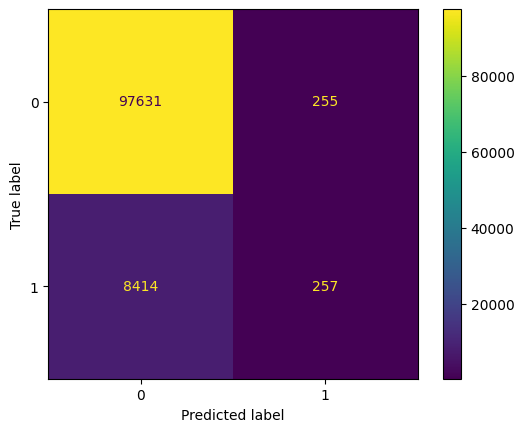

In [121]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

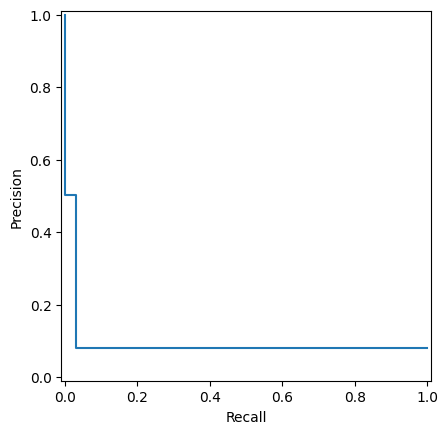

In [122]:
# Plot the precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall).plot()

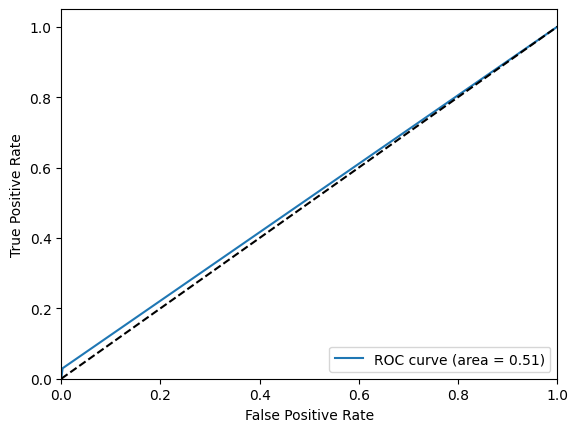

In [123]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [124]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Precision: 0.501953125
Recall: 0.02963902664052589
F1 Score: 0.055972993575084395
ROC AUC: 0.5135169777176232


In [125]:
importance = rf_classifier.feature_importances_
feature_names = X.columns

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)


                       Feature  Importance
4                 rest_avg_cur    0.157550
17             new_setup_tenor    0.131566
0                           id    0.126530
10         rest_dynamic_cur_3m    0.095450
6           amount_rub_atm_prc    0.087076
2           amount_rub_sup_prc    0.071195
5           amount_rub_nas_prc    0.049186
1           amount_rub_clo_prc    0.041325
19  total_turnover_1m_category    0.037391
8                rest_avg_paym    0.036066
14                pack_encoded    0.033485
20  total_turnover_3m_category    0.032171
11        rest_dynamic_paym_3m    0.028871
15             number_products    0.026797
3         rest_dynamic_save_3m    0.021549
16    new_age_category_numeric    0.010231
7         rest_dynamic_fdep_3m    0.005063
12          rest_dynamic_il_3m    0.004612
13          rest_dynamic_cc_3m    0.003281
9     ldeal_grace_days_pct_med    0.000605
18     total_turnover_category    0.000000


In [128]:
threshold = 0.01  # Set your threshold here
selected_features = [i for i, importance in enumerate(importance) if importance >= threshold]
X_train = X_train[:, selected_features]
X_test = X_test[:, selected_features]

In [129]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [130]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Precision: 0.47928994082840237
Recall: 0.028024449313804635
F1 Score: 0.05295271300937023
ROC AUC: 0.5126637172094635


Out of all the instances predicted as churners by the model, around 52.28% of them are actually churners.
The model is able to correctly identify approximately 3.17% of all churners.
An ROC AUC value of approximately 0.514 indicates that the model's ability to discriminate between churners and non-churners is slightly better than random guessing.
After all these considerations, the model can be tuned better with hyperparameters for the bank churn prediction.

In [ ]:
# # Create a new DataFrame with the client or ID and churn prediction
# churn_df = pd.DataFrame({'id': X_test['id'], 'target': y_pred})

# #update this path if you want to use your local
# output_file_key_data_X_train = f'{env}/final/model_one/X_train.csv'
# output_file_key_data_X_test = f'{env}/final/model_one/X_test.csv'

# output_file_key_data_Y_train = f'{env}/final/model_one/Y_train.csv'
# output_file_key_data_Y_test = f'{env}/final/model_one/Y_test.csv'

# output_file_key_data_churn_prediction = f'{env}/final/model_one/churn_prediction.csv'

# # Save the X_train and X_test data to CSV files for checking purposes
# s3_utils.write_csv_to_s3(output_file_key_data_X_train, X_train)
# s3_utils.write_csv_to_s3(output_file_key_data_X_test, X_test)


# # Save the y_train and y_test data to CSV files
# s3_utils.write_csv_to_s3(output_file_key_data_Y_train, y_train)
# s3_utils.write_csv_to_s3(output_file_key_data_Y_test, y_test)

# # Save the churn prediction to a CSV file
# s3_utils.write_csv_to_s3(output_file_key_data_churn_prediction, churn_df)
